In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.datasets import mnist

Problem 1:Looking back on scratch
To implment for deep learing;

I had to initialize weights and baises
I needed an epoch loop to train over data multiple times 
I had to  initialize the nodes of each hidden layer of the network
I performed forward propagation for each layer
I needed to implement an activation function and applied it on the output of each layer
I had to implement a loss function
I had to implement back propagaiton method for the network
I had to train the model using a fit method
I had to implement an optimizer to update the values of weights and baises
I also had to implement a predict method

Problem 2:Considering  the correspondence between scratch and TensorFlow
 
The sample code begins by performing feature selection and data processing on the iris dataset, followed by the definition of the mini batch class. Further down, the paramters for the layers in the class were initilized and assigned values. The exmaple_net function defines the forward propagation operation for the network. Loss_op, train_op, optimizer, and accuracy are used to calculate the loss, forward, backward propagation, and accuracy of the model respectively.
The sample code is a deep learning logistic regression model implemented using tensor flow version 1. The model is trained to learn to distinguish between species of flowers, specifically iris flowers of the versicolor and virginica class.
  
  TensorFlow version one by default uses graph computation, therefore a session has to be created for the training of the model. This session was created using the tf.session method. Within this session, the model is trained.

In [ ]:
class GetMiniBatch:
    """
Iterator to get a mini-batch

    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random seed
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int_)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [ ]:
iris = load_iris()
features = iris["data"]
target = iris["target"]

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

x_train, y_train, x_test, y_test = x_train.astype(np.float32), y_train.astype(np.float32), x_test.astype(np.float32), y_test.astype(np.float32)
y_train = y_train.reshape(-1, 1)
onv = OneHotEncoder(sparse_output=False)
y_train = onv.fit_transform(y_train)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

Problem 3:Creating a model of Iris using all three types of objective variables

In [ ]:



class Layer(tf.Module):
    def __init__(self, n_input, n_output, activation=None, name=None):
        super().__init__(name=name)
        self.weight = tf.Variable(tf.random.normal([n_input, n_output]))
        self.bais = tf.Variable(tf.random.normal([n_output]))
        self.activation = activation

    def __call__(self, x):
        y = tf.add(tf.matmul(x, self.weight), self.bais)
        if self.activation == None:
            return y
        return self.activation(y)


class LogisticRegression:
    def __init__(self, n_input = 4, n_classes=3,  lr=0.01, epoch=100, batch_size = 20):
        self.lr = lr
        self.epoch = epoch
        self.batch = batch_size
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)
        self.inputlayer = Layer(n_input, 100, tf.nn.relu, "InputLayer")
        self.hidden1 = Layer(100, 50, tf.nn.relu, "hidden1")
        self.output = Layer(50,n_classes , name="outputLayer")

    #@tf.function
    def forward(self, x):
        logit = self.inputlayer(x)
        logit = self.hidden1(logit)
        logit = self.output(logit)

        return logit

    def fit(self, x_train, y_train, x_val=None, y_val=None):
        if x_val is None:
            x_val = x_train
            y_val = y_train
        for i in range(self.epoch):
            total_loss = 0
            for mini_x, mini_y in GetMiniBatch(x_train, y_train, self.batch):
                with tf.GradientTape() as tape:
                    logit = self.forward(mini_x)
                    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(mini_y, logit))

                gradient = tape.gradient(loss, tape.watched_variables())
                self.optimizer.apply_gradients(zip(gradient, tape.watched_variables()))
                total_loss+= loss
            total_loss/=self.batch

            with tf.GradientTape() as tape:
                logit = self.forward(x_val)
                loss_val = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_val, logit))
            accuracy = accuracy_score(np.argmax(y_train, 1), self.predict(x_train))
            gradient = tape.gradient(loss_val, tape.watched_variables())
            self.optimizer.apply_gradients(zip(gradient, tape.watched_variables()))

            print(f"Num epoch: {i} loss: {total_loss}: loss_val: {loss_val} accuracy: {accuracy}")
        return self

    def predict(self, x):
        y = tf.nn.softmax(self.forward(x)).numpy()

        return np.argmax(y, 1)


def accuracy_score(y_true, pred):
    correct = np.sum(np.round(y_true) == np.round(pred))
    total = y_true.shape[0]
    return correct/total

In [ ]:
model = LogisticRegression()
model.fit(x_train, y_train, x_val, y_val)

Num epoch: 0 loss: 22.22698974609375: loss_val: 22.45050811767578 accuracy: 0.59375
Num epoch: 1 loss: 9.427495956420898: loss_val: 35.029335021972656 accuracy: 0.65625
Num epoch: 2 loss: 2.692002534866333: loss_val: 15.996060371398926 accuracy: 0.6979166666666666
Num epoch: 3 loss: 1.9227867126464844: loss_val: 3.5300543308258057 accuracy: 0.8125
Num epoch: 4 loss: 0.9897440075874329: loss_val: 0.0006869095377624035 accuracy: 0.96875
Num epoch: 5 loss: 0.4860326647758484: loss_val: 2.3807318210601807 accuracy: 0.90625
Num epoch: 6 loss: 0.21040944755077362: loss_val: 0.022190146148204803 accuracy: 0.9583333333333334
Num epoch: 7 loss: 0.24463710188865662: loss_val: 0.002115904586389661 accuracy: 0.96875
Num epoch: 8 loss: 0.1550915241241455: loss_val: 0.4997902810573578 accuracy: 0.9375
Num epoch: 9 loss: 0.174977108836174: loss_val: 2.155679430870805e-05 accuracy: 0.9583333333333334
Num epoch: 10 loss: 0.07464854419231415: loss_val: 0.6683877110481262 accuracy: 0.9375
Num epoch: 11 l

In [ ]:
pred = model.predict(x_test)

accuracy_score(y_test, pred)

1.0

Text(0, 0.5, 'True value')

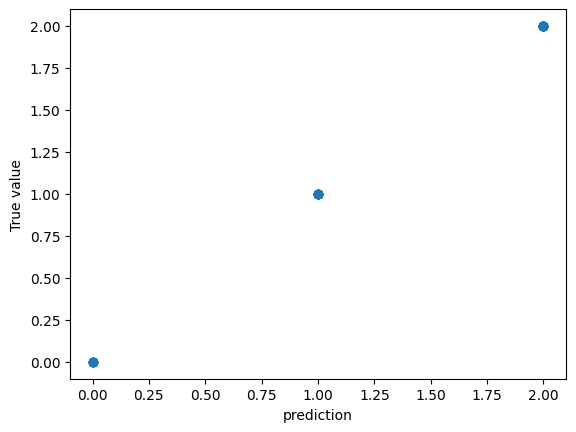

In [ ]:
plt.scatter(pred, y_test)
plt.xlabel("prediction")
plt.ylabel("True value")

Problem 4:Creating a model of House Prices

In [ ]:
house_train = pd.read_csv("C:\Users\cbt04\Dpro_Assignments-\Dpro_Assignments-\train.csv")